# Average cold points (over time) 
average of mins 

In [1]:
import dask

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.gridspec import GridSpec
from dask.diagnostics import ProgressBar


In [2]:
start_date = "2020-01-30"
end_date = "2020-03-01"


In [3]:
file_dir = "/work/bb1153/b380887/global_tropics/"
scratch_dir = "/scratch/b/b380887/"
# save_dir = "/home/b/b380887/cold-point-overshoot/plots/cold_point_time_avg/"
# poster_save_dir = "/home/b/b380887/cold-point-overshoot/plots/agu_poster/"
save_dir = "/home/b/b380887/cold-point-overshoot/plots/d2_paper_poster/cold_point/"


## Make the files
NetCDFs with variables that are time-averaged cold point height and temperature for each model (they're small!)

In [4]:
# model = "NICAM"
# model = "SAM"
# model = "ICON"
# model = "SCREAM"
# model = "SHIELD"
# model = "GEOS"
model = "ERA5"


It's faster to not use dask here for NICAM, SAM, and ICON, but you need it to get the cold point indices of SCREAM, SHiELD, and GEOS for memory management

In [9]:
%%time

if model == "NICAM":
    temp = xr.open_dataset(file_dir + "NICAM/NICAM_0.25deg_temp_12-20km_winter_ITCZ.nc")["ta"].sel(time=slice(start_date, end_date))
    cp_inds = temp.argmin(dim="lev")
    cpT = temp.isel(lev=cp_inds).mean(dim="time")
    cpz = temp.lev.isel(lev=cp_inds).mean(dim="time")

elif model == "SAM":
    temp = xr.open_dataset(file_dir + "SAM/SAM_0.25deg_temp_12-20km_winter_ITCZ.nc")["ta"].sel(time=slice(start_date, end_date))
    cp_inds = temp.argmin(dim="z")
    cpT = temp.isel(z=cp_inds).mean(dim="time")
    cpz = temp.z.isel(z=cp_inds).mean(dim="time")

elif model == "ICON":
    temp = xr.open_dataset(file_dir + "ICON/ICON_temp_0.25deg_12-20km_winter_ITCZ.nc")["ta"].sel(time=slice(start_date, end_date))
    cp_inds = temp.argmin(dim="height")
    alt_i = xr.open_dataset(file_dir + "ICON/ICON_altitude.nc")["height"].sel(lev=temp.height)
    cpT = temp.isel(height=cp_inds).mean(dim="time")
    cpz = alt_i.isel(height=cp_inds).mean(dim="time")
    
elif model == "SCREAM":
    temp = xr.open_dataset(scratch_dir + "SCREAM/SCREAM_temp_0.25deg_12-20km_winter_ITCZ_days10-40.nc")["ta"].sel(time=slice(start_date, end_date))
    with ProgressBar():
        cp_inds = temp.chunk(chunks={"time": 1}).argmin(dim="lev").compute()
    alt_sc = xr.open_dataset(file_dir + "SCREAM/SCREAM_est_height_12-20km.nc")["z"]
    cpT = temp.isel(lev=cp_inds).mean(dim="time")
    cpz = alt_sc.isel(lev=cp_inds).mean(dim="time")

elif model == "SHIELD":
    temp = xr.open_dataset(scratch_dir + "SHiELD/SHIELD_temp_0.25deg_12-20km_winter_ITCZ_days10-40.nc")["ta"].sel(time=slice(start_date, end_date))
    with ProgressBar():
        cp_inds = temp.chunk(chunks={"time": 1}).argmin(dim="pfull_ref").compute()    
    alt_sh = xr.open_dataset(scratch_dir + "SHiELD/SHIELD_zg_0.25deg_12-20km_winter_ITCZ_days10-40.nc")["zg"].sel(time=slice(start_date, end_date))
    cpT = temp.isel(pfull_ref=cp_inds).mean(dim="time")
    cpz = alt_sh.isel(pfull_ref=cp_inds).mean(dim="time")
    
elif model == "GEOS":
    temp = xr.open_dataset(file_dir + "GEOS/GEOS_temp_0.25deg_12-20km_winter_ITCZ_days10-40.nc")["ta"].sel(time=slice(start_date, end_date))
    alt_g = xr.open_dataset(scratch_dir + "GEOS/GEOS_zg_0.25deg_12-20km_winter_ITCZ_days10-40.nc")["zg"]
    with ProgressBar():
        cp_inds = temp.chunk(chunks={"time": 1}).argmin(dim="lev").compute()
    with ProgressBar():
        cpT = temp.isel(lev=cp_inds).mean(dim="time").compute()
    with ProgressBar():
        cpz = alt_g.isel(lev=cp_inds).mean(dim="time").compute()

elif model == "ERA5":
    temp = xr.open_dataset("/scratch/b/b380887/ERA5_temp_0.25deg_ml_12-20km_Feb2020_ITCZ.nc")["t"].sel(time=slice(start_date, end_date))
    alt_e = xr.open_dataset("/scratch/b/b380887/ERA5_zg_0.25deg_ml_ITCZ.nc")["z"].sel(time=slice(start_date, end_date)).sel(level=temp.level).mean(dim="time")/9.80665

    with ProgressBar():
        cp_inds = temp.chunk(chunks={"time": 1}).argmin(dim="level").compute()
    with ProgressBar():
        cpT = temp.isel(level=cp_inds).chunk(chunks={"time": 1}).mean(dim="time").compute()
    with ProgressBar():
        cpz = alt_e.isel(level=cp_inds).chunk(chunks={"time": 1}).mean(dim="time").compute()


/home/b/b380887/.conda/envs/d2env/lib/python3.10/site-packages/xarray/core/indexes.py:97: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  indexer = index.slice_indexer(


[########################################] | 100% Completed | 24.3s
[########################################] | 100% Completed |  7.2s
[########################################] | 100% Completed |  0.4s
CPU times: user 1min 25s, sys: 43.4 s, total: 2min 8s
Wall time: 45.3 s


#### Save the cold point files

In [11]:
out_dir = scratch_dir + "time_avg_cp/"
ds = xr.Dataset({"cpT": cpT, "cpz": cpz})
ds.to_netcdf(out_dir + "{m}_time-mean_cold_point_temp_height_ITCZ.nc".format(m=model))


## Make the plots

Once you have all the files made

In [4]:
# models = ["ERA5", "NICAM", "SAM", "ICON", "SCREAM", "SHIELD", "GEOS"]
models = ["ERA5", "ICON", "GEOS", "SAM", "SCREAM", "SHIELD"]


In [5]:
ds_dict = {}

for model in models:
    ds_dict[model] = xr.open_dataset(file_dir + "time_avg_cp/{m}_time-mean_cold_point_temp_height_ITCZ.nc".format(m=model))
    

In [6]:
title_dict = {
    "SAM": "gSAM",
    "SHIELD": "X-SHiELD",
    "ICON": "ICON",
    "GEOS": "GEOS", 
    "SCREAM": "SCREAM",
    "ERA5": "ERA5 (Feb. 2020)"
}


Means

In [12]:
for model in models:
    cpT_avg = ds_dict[model]["cpT"].mean()
    cpz_avg = ds_dict[model]["cpz"].mean()
    print(model, cpT_avg.values, cpz_avg.values/1000.)
    

ERA5 192.55978 17.280130859375
ICON 192.08482 17.28761808044846
GEOS 192.60614 17.3858828125
SAM 190.19948 16.96699232235172
SCREAM 192.76949 17.367844029114686
SHIELD 191.8517 17.7643671875


Need this helper function

In [8]:
def get_lonlat_labs(lons, lats, print_labs=False):
    """ Get string labels for lat & lon plots (deg N/S/E/W)
    """
    lats_lab = [str(abs(x)) for x in lats]
    lons_lab = [str(abs(x)) for x in lons]

    for i, lon in enumerate(lons):
        if lon == 0 or abs(lon) == 180:
            lons_lab[i] += "°"
        elif lon < 0:
            lons_lab[i] += "° W"
        elif lon > 0:
            lons_lab[i] += "° E"

    for i, lat in enumerate(lats):
        if lat < 0:
            lats_lab[i] += "° S"
        elif lat > 0:
            lats_lab[i] += "° N"
        else:
            lats_lab[i] += "°"
            
    if print_labs:
        print(lons_lab)
        print(lats_lab)
        
    return lons_lab, lats_lab


### Plot all models together (temperature or height)

To get the vmin and vmaxes:

In [9]:
for model in models:
    print(model, ds_dict[model]["cpT"].min().values, ds_dict[model]["cpT"].max().values)
print("\n")
for model in models:
    print(model, ds_dict[model]["cpz"].min().values/1000., ds_dict[model]["cpz"].max().values/1000.)
    

ERA5 186.93721 205.6902
ICON 186.04948 204.06877
GEOS 188.53035 203.97736
SAM 185.0933 202.26808
SCREAM 188.1743 204.81622
SHIELD 186.14716 204.51274


ERA5 16.1829716796875 18.3967578125
ICON 15.972690776209678 18.431013176843315
GEOS 16.0573525390625 18.39141796875
SAM 14.78915736438382 17.844253807806197
SCREAM 15.835937349146747 17.99516725255798
SHIELD 15.764962890625 18.7109765625


In [34]:
def plot_avg_cold_points(ds_dict, var, title_dict=None, fsize=18, tsize=22, figwidth=16, figheight=3, figsize=None, 
                         coastline=False, save=False, central_lon=0, labsize=12, cmap="viridis", relative_cmap=False):
    """ Plot time-averaged global tropcis cold point height or temperature for many models. 
    """
    if var == "cpT":
        units = "K"
        long_name = "Temperature"
        short_name = "temp"
        vmin = 183
        vmax = 204
        m = 1.0
        # cmap = cmap #"viridis"
    elif var == "cpz":
        units = "km"
        long_name = "Height"
        short_name = "height"
        vmin = 14.5
        vmax = 18.5
        m = 0.001
        # cmap = cmap + "_r" #"viridis_r"
    else:
        raise Exception("variable \'{}\' not found; must be \'cpT\' or \'cpz\'".format(var))   
        
    # added to match 
    plot_lons = [*np.arange(-100, 181, 40), *np.arange(-140, -99, 40)]
    plot_lats = np.arange(-30, 11, 10)
    
    # set "0" color value to be the tropics-mean cpT and cpz
    if relative_cmap:
        obs_mean_cpT = ds_dict["ERA5"]["cpT"].mean().values
        obs_mean_cpz = ds_dict["ERA5"]["cpz"].mean().values/1000.
        cpT_range = 8#12
        cpz_range = 1.5#2.5
        if var == "cpz":
            vmin = obs_mean_cpz-cpz_range
            vmax = obs_mean_cpz+cpz_range
        elif var == "cpT":
            vmin = obs_mean_cpT-cpT_range
            vmax = obs_mean_cpT+cpT_range

    models = list(ds_dict.keys())
    nrows = len(models) + 1
    height_ratios = [1]*len(models) + [0.25]
    
    if figsize is None:
        figsize = (figwidth, figheight*len(models))
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(nrows, 6, height_ratios=height_ratios, hspace=1, wspace=0.4)
    axes = [plt.subplot(gs[i, :], projection=ccrs.PlateCarree(central_longitude=central_lon)) for i in range(nrows-1)]
    ax_cb = plt.subplot(gs[-1, 1:5])
        
    for i, model in enumerate(models):
        if model == "ERA5":
            lons = ds_dict[model].longitude % 360
            pcm = axes[i].pcolormesh(lons-central_lon, ds_dict[model].latitude, ds_dict[model][var]*m, cmap=cmap,
                                     vmin=vmin, vmax=vmax)
        else:
            pcm = axes[i].pcolormesh(ds_dict[model].lon-central_lon, ds_dict[model].lat, ds_dict[model][var]*m, cmap=cmap,
                                     vmin=vmin, vmax=vmax)
        if title_dict is not None:
            axes[i].set_title(title_dict[model], fontsize=tsize)
        else:
            axes[i].set_title(model, fontsize=tsize)

        # print max
        if var == "cpT":
            print(model, (ds_dict[model][var]*m).max().values)
        
    cbar = plt.colorbar(pcm, cax=ax_cb, orientation="horizontal", extend="both")
    cbar.set_label("Time-mean Cold Point {n} ({u})".format(n=long_name, u=units), fontsize=fsize)
    cbar.ax.tick_params(labelsize=labsize)
    
    for ax in axes:
        # gridlines
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                            xlocs=plot_lons, ylocs=plot_lats, x_inline=False, y_inline=False, color = "None")
        gl.top_labels = False
        gl.right_labels = False
        gl.xlabel_style = {'size': labsize, 'rotation': 0}#20}
        gl.ylabel_style = {'size': labsize}
        ax.add_feature(cfeature.COASTLINE, linewidth=2)
        ax.set_ylim((plot_lats[0], plot_lats[-1]))
    
            
    if save:
        inits = ""
        for m in models:
            inits += (m[0] + m[1].lower())
        plt.savefig(save_dir + "{i}_time_avg_cold_point_{s}_ITCZ.png".format(i=inits, s=short_name),
                    dpi=300, bbox_inches="tight")

    plt.show()
    
    

In [31]:
obs_mean_cpT = ds_dict["ERA5"]["cpT"].mean().values
obs_mean_cpz = ds_dict["ERA5"]["cpz"].mean().values
print(obs_mean_cpT, obs_mean_cpz/1000.)

192.55978 17.280130859375


In [32]:
# cmap="bwr"
cmap = "Spectral_r"
figsize = (17, 22)
labsize = 28
fsize = 36
tsize = 40

ERA5 205.6902
ICON 204.06877
GEOS 203.97736
SAM 202.26808
SCREAM 204.81622
SHIELD 204.51274


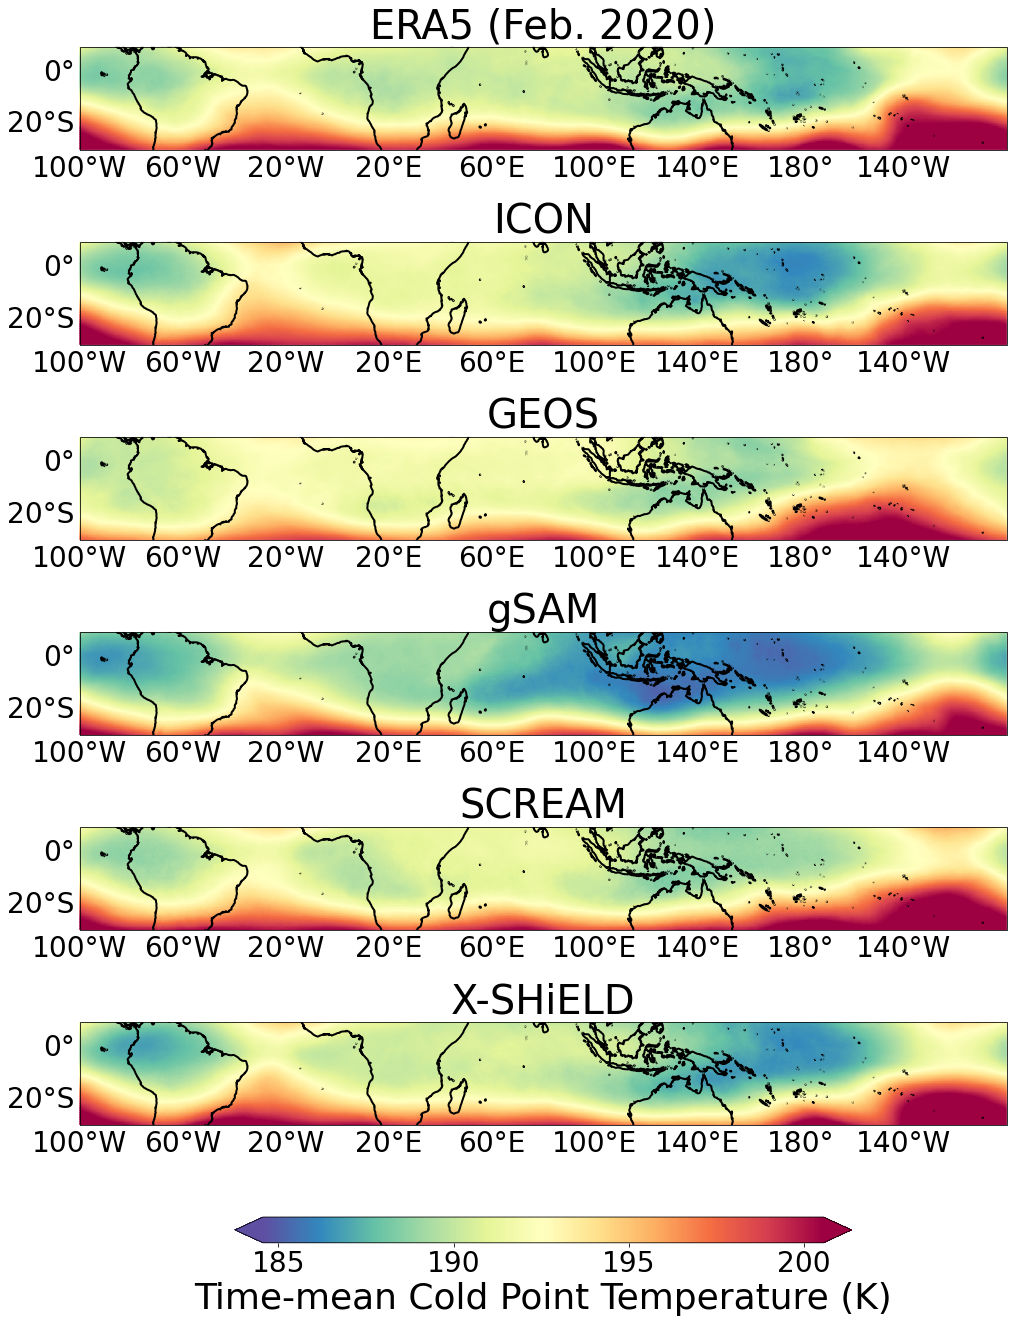

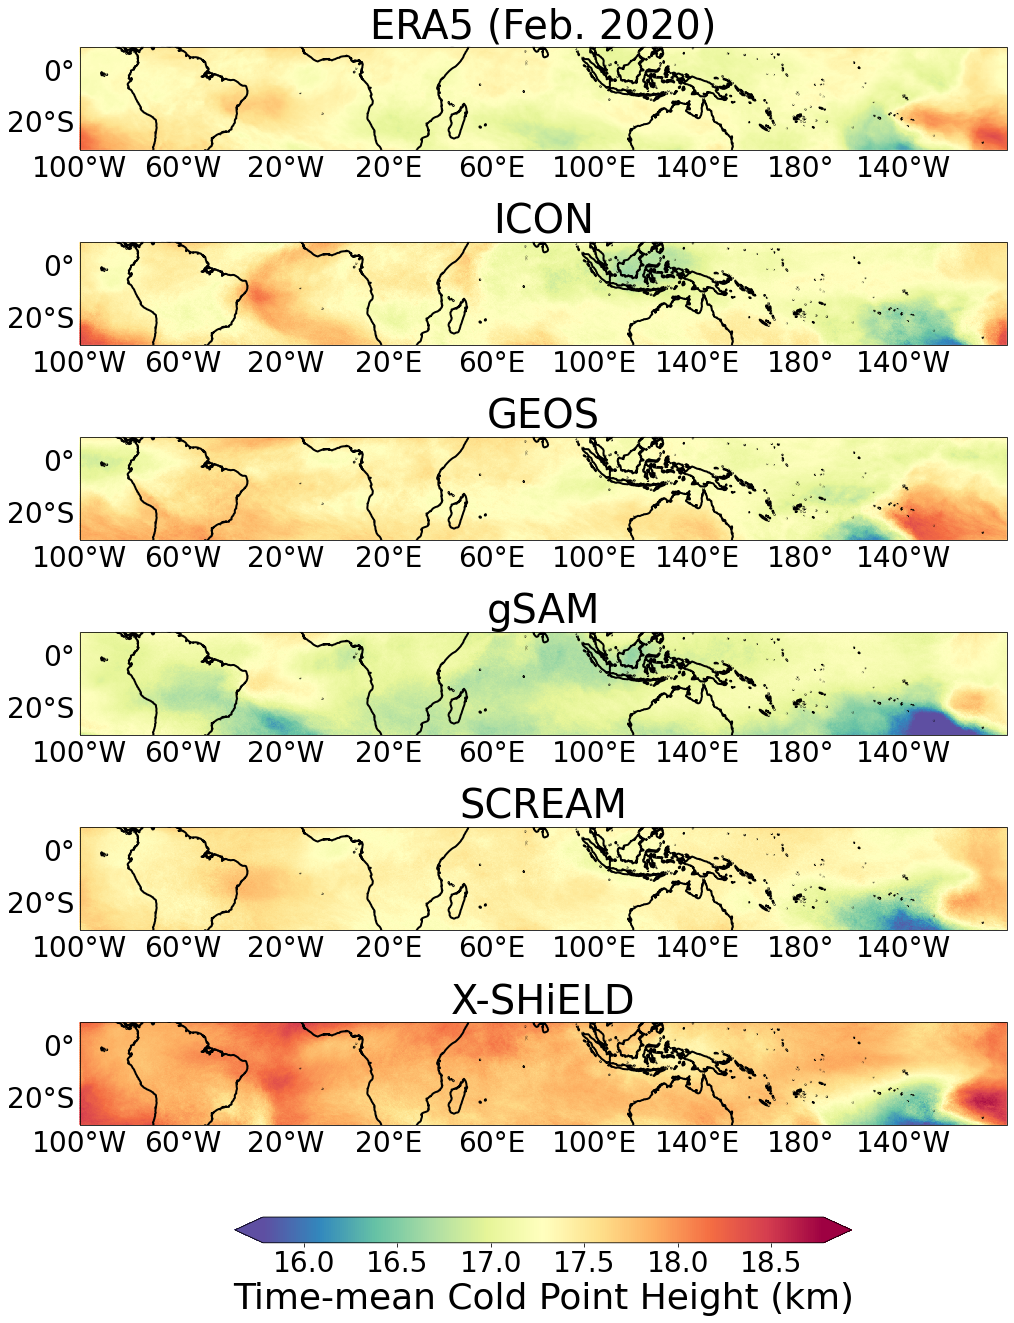

In [35]:
plot_avg_cold_points(ds_dict, "cpT", figsize=figsize, save=True, central_lon=80, tsize=tsize, labsize=labsize, 
                     fsize=fsize, title_dict=title_dict, cmap=cmap, relative_cmap=True)
plot_avg_cold_points(ds_dict, "cpz", figsize=figsize, save=True, central_lon=80, tsize=tsize, labsize=labsize, 
                     fsize=fsize, title_dict=title_dict, cmap=cmap, relative_cmap=True)
